# 1. Data cleaning

In [2]:
! pip install pandas
! pip install numpy
! pip install nltk
! pip install wordcloud
! pip install sklearn
! pip install seaborn
! pip install matplotlib

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import unicodedata
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#reading the csv files to dataframe
sa_data = pd.read_csv('sentiment_analysis.csv')
ce_data = pd.read_csv('Canadian_elections_2021.csv')

In [ ]:
#printing first 5 rows from generic tweets data
sa_data.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [ ]:
#printing first 5 rows from canadian elections data
ce_data.head()

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


In [ ]:
#extracting all the tags and hashtags from the generic tweets data and canadian elections data
sa_tags = sa_data.text.str.extractall(r'(\@\w+)')[0].value_counts()
sa_hash = sa_data.text.str.extractall(r'(\#\w+)')[0].value_counts()
ce_tags = ce_data.text.str.extractall(r'(\@\w+)')[0].value_counts()
ce_hash = ce_data.text.str.extractall(r'(\#\w+)')[0].value_counts()

In [ ]:
#creating function to remove RT in given text
def RT_removal(text):
  cleantext = re.sub('RT', '', text)
  return cleantext

In [ ]:
#removal of RT(Retweet word)
sa_data.text = sa_data.text.apply(RT_removal)
ce_data.text = ce_data.text.apply(RT_removal)

**1.1 All html tags and attributes (i.e., /<[^>]+>/) are removed.**

In [ ]:
#Regex is used to clean the HTML tags and attributes including the '&nsbm'
def remove_html_tagattr(text):
  cleantext = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});','',text)
  return cleantext

In [ ]:
#calling the html tags and attributes removal function
sa_data.text = sa_data.text.apply(remove_html_tagattr)
ce_data.text = ce_data.text.apply(remove_html_tagattr)

**1.2 Html character codes (i.e., &...;) are replaced with an ASCII equivalent.**

In [ ]:
#created function to converting all the name and numeric character references 
#in the string to the Unicode characters and decode it back to the string

def decode(text):
  cleantext = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
  return cleantext

In [ ]:
#calling the decode funtion on the tweets text
sa_data.text = sa_data.text.apply(decode)
ce_data.text = ce_data.text.apply(decode)

**1.3 All URLs are removed.**

In [ ]:
#all urls are removed from the text
def remove_urls(text):
    cleantext = re.sub(r'http\S+', '', text)
    cleantext = re.sub(r'www\S+', '', cleantext)
    return cleantext

In [ ]:
#calling url removal function on the tweets text
sa_data.text = sa_data.text.apply(remove_urls)
ce_data.text = ce_data.text.apply(remove_urls)

**1.4 All characters in the text are in lowercase.**

In [ ]:
#converting text to lower case
def to_lower(text):
  cleantext = text.lower()
  return cleantext

In [ ]:
#calling lowercase convertion function on the tweets text
sa_data.text = sa_data.text.apply(to_lower)
ce_data.text = ce_data.text.apply(to_lower)

In [ ]:
#Before performing the stop words removal and lemmatization action cleaning the data(i.e., removal of emojis, unwanted spaces, and special characters)
def pre_clean(text):
  cleantext = re.sub(r'[^a-zA-Z ]+', '', text)
  cleantext = cleantext.strip()
  return cleantext

In [ ]:
#performing pre cleaning on the tweets text
sa_data.text = sa_data.text.apply(pre_clean)
ce_data.text = ce_data.text.apply(pre_clean)

**1.5 All stop words are removed.**

In [ ]:
#Removing all the stop words from the text and performing lemmatization for text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def removal_of_stopwords_and_lemmatize(text):
  cleantext = ''
  word_tokens = word_tokenize(text)
  for word in word_tokens:
    word = lemmatizer.lemmatize(word)
    if word not in stop_words:
      cleantext = cleantext + ' ' + word

  cleantext = cleantext.strip()
   
  return cleantext

In [ ]:
#calling stop words removal and lemmatization on tweets text
sa_data.text = sa_data.text.apply(removal_of_stopwords_and_lemmatize)
ce_data.text = ce_data.text.apply(removal_of_stopwords_and_lemmatize)

# 2. Exploratory analysis 

**2.1 Determining the tweet belongs to which political party**

The below keywords for each party are gathered from the web, twitter and Wikipedia.

In [ ]:
liberal = ['jean','yves' ,'duclos','bill','blair','bill blair','billblair','marie', 'claude', 'barrette',
           'carolyn','bennett','anita','anand','anitaanand','anita anand','omar','alghabra','chrystia',
           'freeland','randy boissonnault','randy', 'boissonnault','sonia','sidhu','lpc','sophie', 'bardish','free','glorious',
           'gregoire','leadership of the liberal party','canadian avalanche association','socialism','chagger','socialism',
           'katimavik','pierre', 'trudeau','joe clark','liberalism','justintrudeau','trudeau','ottawa','trudeaugovernment','fored',
           'justin','justin trudeau','liberal', 'forwardforeveryone','liberals','immigration','istandwithtrudeau','integrity','openness',
           'partiliberal','liberal party','liberal party of canada','suzanne', 'cowan', 'justintrudeau4canada', 'adam','patty','mark',
           'trudeauism','liberal party of canada leadership elections','teamtrudeau','votefortrudeau', 'blackface','sean','karian',
           'votetrudeau','votetotrudeau','voteforliberals','votetoliberals','voteliberals', 'weed', 'scheerweakness','mona','bestpm','lib',
           'voteforliberal','votetoliberal','voteliberal','voteliberalmajority','istandwithtrudeau', 'trudeaumania','barack','pmjt','jt'
           'liberalparty','safercanada','protect','oureconomy','chooseforward','forward','pm','vankayak','koeverden','mckenna','lavalin',
           'trudeaumuststay','primeminister','primeministerofcanada','progressive' , 'inclusive', 'red','obama','realchange','change',
           'connor','forchange','lowertaxes','voteforcanada','stronger','together','medicareforall','neverscheer','lib','justtrudeau']

conservative = ['conservative party of canada','cpc','cpcwins','voteforcpc','votetocpc','votecpc',
                'parti conservateur du canada','tories','red tories','blue tories','redtories','bluetories',
                'big tent','bigtent','leader of the official opposition','erin','otoole','erinmichael','andrew',
                'jamesfburnett','burnett','scheer','andrew scheer','erinmichaelotoole','otooleforpm','canzuk',
                'candice','bergen','andrew', 'scheer','conservative','stephentaylor','steven','taylor',
                'jason','kenny','cpchq','cpc','ford','harper','kinsella','stephen']

ndp = ['new democratic','votendp','voteforndp','votetondp','jagmeet','democratic party','ndp','thejagmeetsingh','matthew green',
       'green','singh','uprisingh','new democrats','newdemocrats','nouveaupartidémocratique','npd','co-operative commonwealth federation',
       'huges','niki ashton','ccf','canadian labour congress', 'clc','indo-canadian','dhananjai', 'kohli','anne', 'mcgrath','alexandre',
       'boulerice','lisa marie barron','barron','peter', 'julian','leader of the new democratic party','ndpleader',' burnaby','south',
       'gurkiran', 'kaur','randall garrison','garrison','sidhu','carol hughes','ashton''lindsay mathyssen','mathyssen','jenny kwan',
       'kwan','jagmeet','tommulcair']

ppc = ['maxime bernier','votetomax','voteformax','voteppc','votetoppc','voteforppc','bernier','ppc','steven fletcher','fletcher',
       'max','votemaxime','peoples party of canada', 'electoral district associations', 'populist','beauce','peoples','catherine',
       'letarte']

In [ ]:
#creating a new column to add party name for each tweet
ce_data['party'] = 'none'

#assigning party names for each row if tweets text contains the key words for each party
ce_data.loc[ce_data['text'].str.contains('|'.join(liberal)),'party']= 'liberal'
ce_data.loc[ce_data['text'].str.contains('|'.join(conservative)),'party']= 'conservative'
ce_data.loc[ce_data['text'].str.contains('|'.join(ndp)),'party']= 'ndp'
ce_data.loc[ce_data['text'].str.contains('|'.join(ppc)),'party']= 'ppc'

#count of tweets which belongs to each party
ce_data.party.value_counts()

liberal         324
conservative    322
none            146
ppc             114
ndp              96
Name: party, dtype: int64

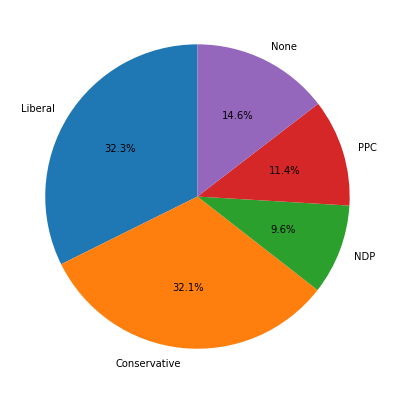

In [ ]:
#creating datasets
parties = ['Liberal', 'Conservative', 'NDP', 'PPC', 'None'] 
total = len(ce_data.party)
weights = [ce_data.party.value_counts()['liberal']/total, ce_data.party.value_counts()['conservative']/total,
           ce_data.party.value_counts()['ndp']/total, ce_data.party.value_counts()['ppc']/total, ce_data.party.value_counts()['none']/total]

#creating pie-plot
fig = plt.figure(figsize =(10, 7))
plt.pie(weights, labels = parties, autopct='%1.1f%%', startangle=90)
  
#show plot
plt.show()

From the above pie plot, In the given data, we predicted that 32.3% of tweets belong to the Liberal Party, 32.1% of tweets belong to the Conservative party, and 11.4%, 9.6% of tweets for PPC and NDP. The remaining 14.6% of tweets haven't been classified.

**2.2 Presenting graphical figure**

**2.2.1 Data exploration for sentiment_analysis.csv**

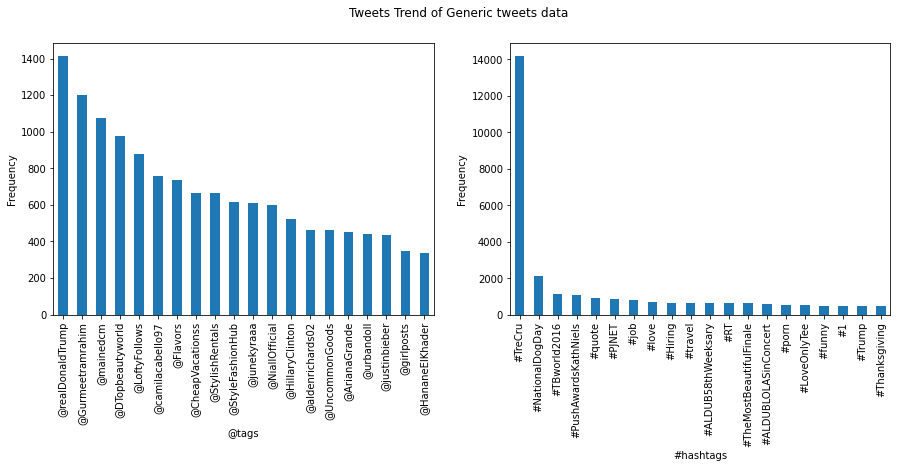

In [ ]:
#trend for generic tweets
fig, axes = plt.subplots(1,2)

sa_tags[:20].plot(kind= 'bar',ax = axes[0],figsize = (15,5))
fig.suptitle('Tweets Trend of Generic tweets data')
axes[0].set_xlabel('@tags')
axes[0].set_ylabel('Frequency')


sa_hash[:20].plot(kind= 'bar',ax = axes[1])
axes[1].set_xlabel('#hashtags')
axes[1].set_ylabel('Frequency')
plt.show()

We can observe which tags and hashtags are repeated the most in the generic tweets data from the above bar plots. In the generic tweets data, the highest tags counts were of @realDonaldTrump, which could be positive or negative tweets tags. In the hashtags subplot barplot, the #TreCru holds the highest count.

In [ ]:
#writing common function to find out top n most commonly repeated words in the generic tweets data
def top_words(data,top=10):
  all_words = data.apply(lambda words: words.split(" "))
  all_words = pd.Series(chain.from_iterable(all_words))
  top_words = all_words.value_counts()[:top]
  top_words = pd.DataFrame(top_words)
  top_words.reset_index(inplace=True)
  top_words.columns = ['word','count']

  return top_words

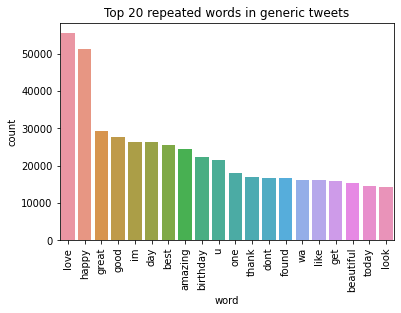

In [ ]:
#plotting top 20 generic tweets dataset tweet words
top_20_sa_words = top_words(sa_data.text,20)
sns.barplot(x = 'word', y = 'count', data = top_20_sa_words)
plt.title('Top 20 repeated words in generic tweets')
plt.xticks(rotation=90)
plt.show()

The above barplot represents the top 20 most repeated words in the generic tweets. Love has 55,000+ occurrences, and happy has more than 50,000 occurrences.

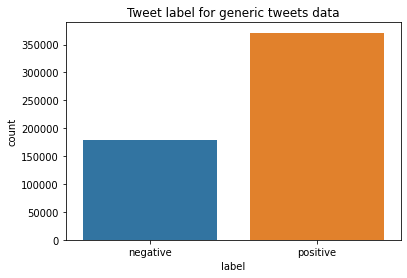

In [ ]:
sns.countplot(x = 'label',data = sa_data)
positions = (0,1)
labels = ('negative','positive')
plt.title('Tweet label for generic tweets data')
plt.xticks(positions, labels)
plt.show()

The count plot represents the variation in the count between positive and negative tweets in the generic tweets data. We can observe that we have approximately twice the count of positive tweets than negative tweets.

In [ ]:
#adding a new column to the data frame, which represents the word count for each tweet
sa_data['word_count'] = sa_data['text'].apply(lambda x: len(x.split()))
ce_data['word_count'] = sa_data['text'].apply(lambda x: len(x.split()))

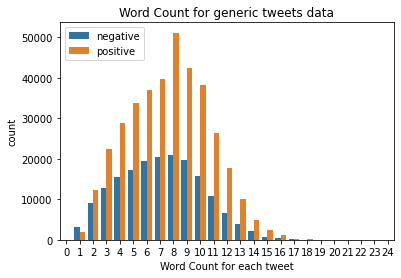

In [ ]:
#ploting word count count plot
sns.countplot(x = 'word_count',hue = 'label', data = sa_data)
plt.legend(['negative','positive'])
plt.xlabel('Word Count for each tweet')
plt.title('Word Count for generic tweets data')
plt.show()

From the above count plot, we can observe that as the words count in the tweets count increases, the count of tweets also increases and reaches the maximum at the eight-worded tweet count for each tweet and then decreases.

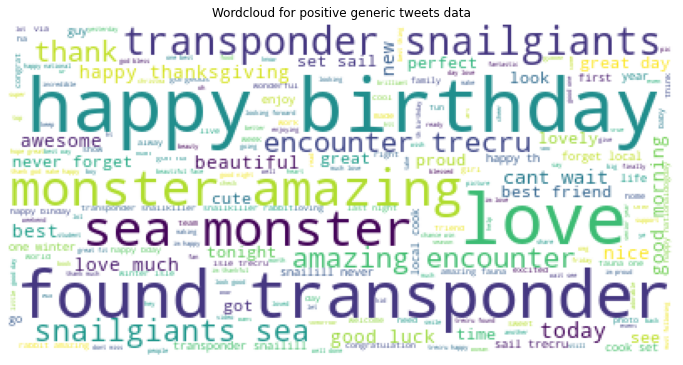

In [ ]:
#wordcloud for positive generic tweets data
tweets = sa_data.text[sa_data.label == 1]
tweets_combined = []

for t in tweets:
    tweets_combined.append(t)
tweets_combined = pd.Series(tweets_combined).str.cat(sep=' ')

wordcloud = WordCloud(background_color ='white').generate(tweets_combined)

#plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title('Wordcloud for positive generic tweets data')
plt.axis("off")
plt.show()

The above word cloud represents the words from positive tweets in generic tweets data. We can see that happy, love, sea, and birthday are repeated in the positive tweets.

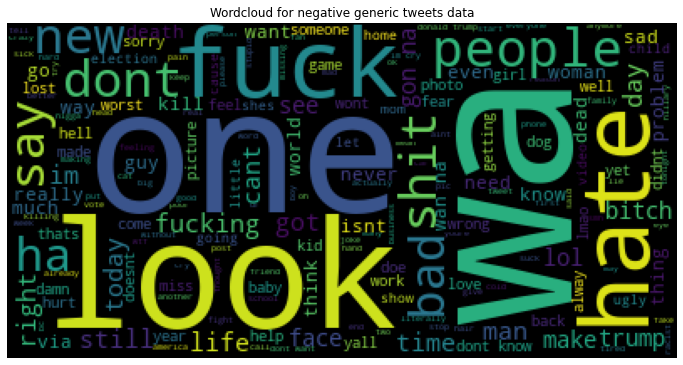

In [ ]:
#wordcloud for negative generic tweets data
tweets = sa_data.text[sa_data.label == 0]
tweets_combined = []

for t in tweets:
    tweets_combined.append(t)
tweets_combined = pd.Series(tweets_combined).str.cat(sep=' ')

wordcloud = WordCloud(background_color ='black').generate(tweets_combined)

#plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title('Wordcloud for negative generic tweets data')
plt.axis("off")
plt.show()

The above word cloud represents the words from negative tweets in sgeneric tweets data. We can see look, one, hate, and shit repeated the most in the negative tweets.

**2.2.2 Data exploration for Canadian Elections tweets**

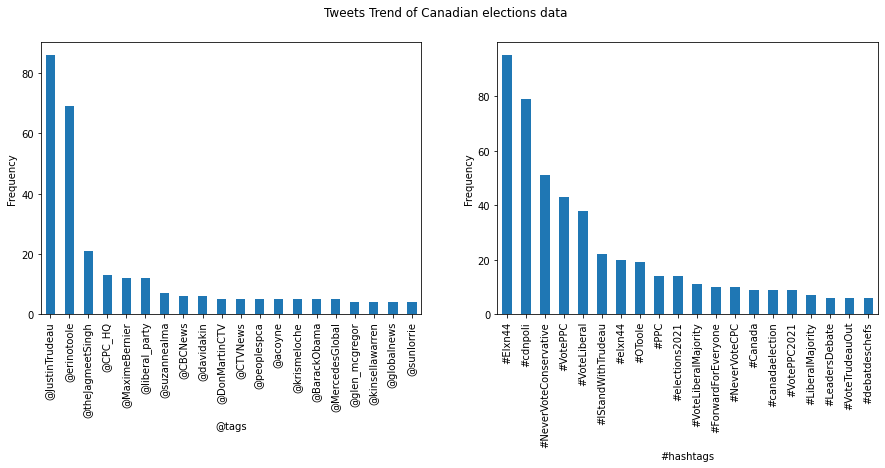

In [ ]:
#trend for canadian elections
fig, axes = plt.subplots(1,2)

ce_tags[:20].plot(kind= 'bar',ax = axes[0],figsize = (15,5))
fig.suptitle('Tweets Trend of Canadian elections data')
axes[0].set_xlabel('@tags')
axes[0].set_ylabel('Frequency')

ce_hash[:20].plot(kind= 'bar',ax = axes[1])
axes[1].set_xlabel('#hashtags')
axes[1].set_ylabel('Frequency')
plt.show()

From the above subplots, we can observe the trend in the tags and the hashtags in the Canadian elections data.<br>
From the first subplot, we can observe there is extensive tagging for the JustinTrudeau, Otoole, and JagmeetSingh.<br>
The second subplot shows that the most common hashtags are #Elxn44, #cdnploe, and #NeverVoteConservative.

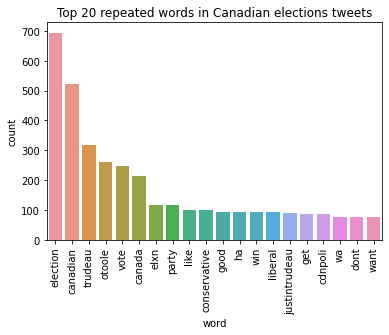

In [ ]:
#plotting top 20 generic tweets dataset tweet words
top_20_ce_words = top_words(ce_data.text,20)
sns.barplot(x = 'word', y = 'count', data = top_20_ce_words)
plt.title('Top 20 repeated words in Canadian elections tweets')
plt.xticks(rotation=90)
plt.show()

The above plot represents the top 20 most common repeated words in the Canadian elections tweets data. We can observe that the election, Canadian, and Trudeau are the most repeated words in the tweets.

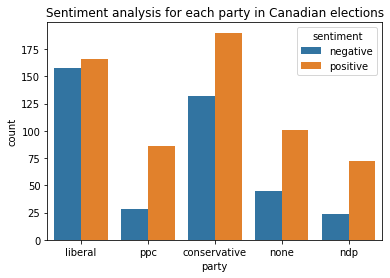

In [ ]:
sns.countplot(x = 'party',data = ce_data, hue = 'sentiment')
plt.title('Sentiment analysis for each party in Canadian elections')
plt.show()

The above count plot represents the distribution of each party's positive and negative tweets in the Canadian elections.

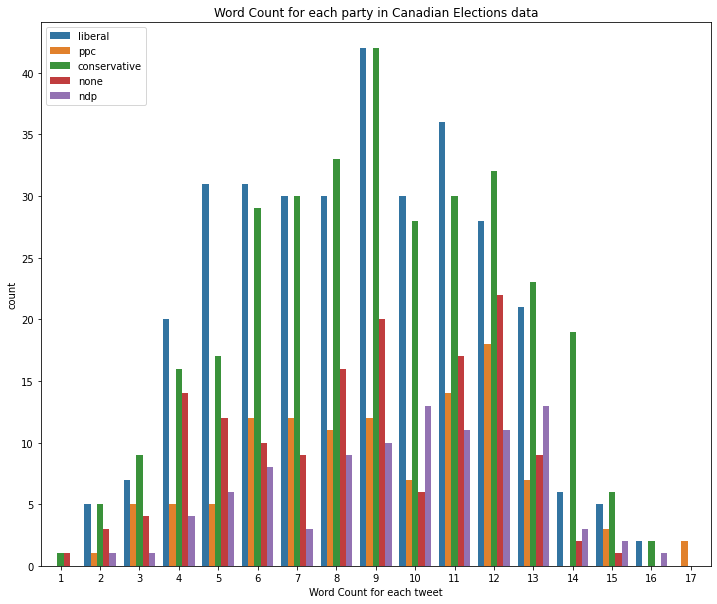

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'word_count',hue = 'party', data = ce_data)
plt.xlabel('Word Count for each tweet')
plt.legend(loc='upper left')
plt.title('Word Count for each party in Canadian Elections data')
plt.show()

This graph represents the trend in word count for each tweet text respective to each party.

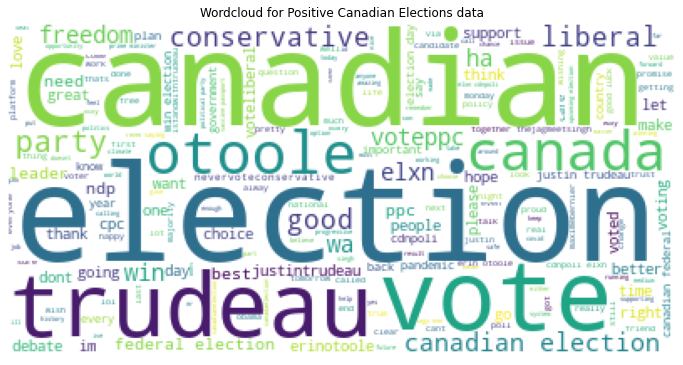

In [ ]:
#wordcloud for positive canadian elections data
tweets = ce_data.text[ce_data.sentiment == 'positive']
tweets_combined = []

for t in tweets:
    tweets_combined.append(t)
tweets_combined = pd.Series(tweets_combined).str.cat(sep=' ')

wordcloud = WordCloud(background_color ='white').generate(tweets_combined)

#plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title('Wordcloud for Positive Canadian Elections data')
plt.axis("off")
plt.show()

The above word cloud is created using the words from positive tweets in the Canadian elections data. Here we can observe that word cloud highlights election, Canadian, vote, and Trudeau, which are the most repeated words in the text of the tweets.

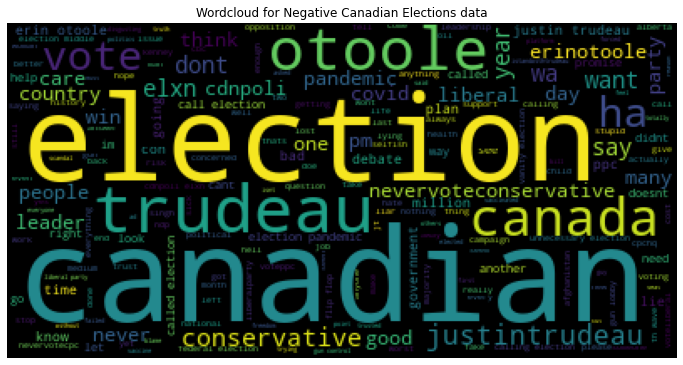

In [ ]:
#wordcloud for negative canadian elections data
tweets = ce_data.text[ce_data.sentiment == 'negative']
tweets_combined = []

for t in tweets:
    tweets_combined.append(t)
tweets_combined = pd.Series(tweets_combined).str.cat(sep=' ')

wordcloud = WordCloud(background_color ='black').generate(tweets_combined)

#plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title('Wordcloud for Negative Canadian Elections data')
plt.axis("off")
plt.show()

The above word cloud is created using the words from negative tweets in the Canadian elections data. Here we can observe that word cloud highlights Trudeau, Canadian, election, and otoole, which are the most repeated words in the text of the tweets.

# 3.Model preparation 

In [ ]:
#extracting the text of the tweet from the generic tweets data and using those as the model features
X = sa_data.text.astype(str)

#extracting target variables generic tweets data
y = sa_data.label

#splitting the total data as 70% of train data and 30% of test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 9)

In [ ]:
print('Count of Total Set:', len(X))
print('Count of Train Set:', len(X_train))
print('Count of Test Set :', len(X_test))

Count of Total Set: 550391
Count of Train Set: 385273
Count of Test Set : 165118


In [ ]:
#creating vector objects for bag of words and TF-IDF
bag_of_words = CountVectorizer()
tf_idf = TfidfVectorizer()

In [ ]:
#fitting and transforming the train and test data on the bag of words feature type
bag_of_words_X_train = bag_of_words.fit_transform(X_train)
bag_of_words_X_test = bag_of_words.transform(X_test)

#fitting and transforming the train and test data on the TF-IDF feature type
tf_idf_X_train = tf_idf.fit_transform(X_train)
tf_idf_X_test = tf_idf.transform(X_test)

In [ ]:
#printing only first ten rows in the bag of words features train data, avoid the system crash
bag_of_words_df = pd.DataFrame(bag_of_words_X_train[:10].toarray(),columns=bag_of_words.get_feature_names())
bag_of_words_df

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaand,aaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhh,aaaaaaaaaaaaaaarrrrrrgh,aaaaaaaaaaaakkkkkkk,aaaaaaaaaaah,aaaaaaaah,aaaaaaaahhhh,aaaaaaaandyc,aaaaaaaannnnd,aaaaaaaathank,aaaaaaand,aaaaaah,aaaaaakkkthanks,aaaaaand,aaaaaaw,aaaaagh,aaaaahh,aaaaahhh,aaaaaight,aaaaallllllll,aaaaalyssia,aaaaar,aaaaargh,aaaadnyl,aaaah,aaaahh,aaaahhh,aaaahhhh,aaaand,...,zxxchh,zxynisgod,zxyyumi,zyanidesun,zydtrip,zyelonkimble,zygote,zyklon,zylbrad,zylerthecat,zylfia,zynga,zypags,zyphroxvg,zyra,zyrahalvi,zyrahso,zyrasalva,zyxarchive,zyxiumin,zyzhao,zz,zzdillah,zzen,zzicboo,zzirfish,zzoey,zzsylvester,zztommy,zztop,zzungry,zzz,zzzonbi,zzzquil,zzzs,zzzz,zzzzs,zzzzz,zzzzzzcredit,zzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#printing only first ten rows in the TF-IDF features train data, avoid the system crash
tf_idf_df=pd.DataFrame(tf_idf_X_train[:10].toarray(),columns=tf_idf.get_feature_names())
tf_idf_df

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaand,aaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhh,aaaaaaaaaaaaaaarrrrrrgh,aaaaaaaaaaaakkkkkkk,aaaaaaaaaaah,aaaaaaaah,aaaaaaaahhhh,aaaaaaaandyc,aaaaaaaannnnd,aaaaaaaathank,aaaaaaand,aaaaaah,aaaaaakkkthanks,aaaaaand,aaaaaaw,aaaaagh,aaaaahh,aaaaahhh,aaaaaight,aaaaallllllll,aaaaalyssia,aaaaar,aaaaargh,aaaadnyl,aaaah,aaaahh,aaaahhh,aaaahhhh,aaaand,...,zxxchh,zxynisgod,zxyyumi,zyanidesun,zydtrip,zyelonkimble,zygote,zyklon,zylbrad,zylerthecat,zylfia,zynga,zypags,zyphroxvg,zyra,zyrahalvi,zyrahso,zyrasalva,zyxarchive,zyxiumin,zyzhao,zz,zzdillah,zzen,zzicboo,zzirfish,zzoey,zzsylvester,zztommy,zztop,zzungry,zzz,zzzonbi,zzzquil,zzzs,zzzz,zzzzs,zzzzz,zzzzzzcredit,zzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# 4. Model Implementation and Tuning

In [ ]:
#to hold all the outputs for each model run
outputs = list()

#creating a standard function, which fits the data to the model and prints the metrics
def run_model(model,word_type = 'bag_of_words'):

  predict_train = np.empty
  predict_test = np.empty

  if word_type == 'bag_of_words':

    print('Traning and testing on the:', str(model), 'model, using Bag of words features.')
    print('---------------------------------------------------------------------')
    model.fit(bag_of_words_X_train, y_train)

    #making prediction on the train set
    predict_train = model.predict(bag_of_words_X_train)
    #making prediction on the test set
    predict_test = model.predict(bag_of_words_X_test)

  else:

    print('Traning and testing on the:',str(model),'model, using TF-IDF features.')
    print('---------------------------------------------------------------------')
    model.fit(tf_idf_X_train, y_train)

    #making prediction on the train set
    predict_train = model.predict(tf_idf_X_train)
    #making prediction on the test set
    predict_test = model.predict(tf_idf_X_test)

  #evaluating the model
  accuracy_train = accuracy_score(predict_train, y_train)
  accuracy_test = accuracy_score(predict_test, y_test)

  #calculating the F1_Score
  f1_test = f1_score(predict_test, y_test)

  #calculating precision and recall
  precision_test = precision_score(predict_test, y_test)
  recall_test = recall_score(predict_test, y_test)

  #appending values to the outputs list
  outputs.append([str(model),word_type,accuracy_train,accuracy_test,f1_test,precision_test,recall_test])

  print('Accuracy for Train data:', accuracy_train)
  print('Accuracy for Test data:', accuracy_test)
  print('F1_score:', f1_test)
  print('Precision Score:', precision_test)
  print('Recall Score:', recall_test)
  print('---------------------------------------------------------------------\n')

Performing seven classification algorithms on the Bag of words and TF-IDF feature types.

**Logistic Regression**

In [ ]:
logreg = LogisticRegression()
run_model(logreg,'bag_of_words')
run_model(logreg,'tf-idf')

Traning and testing on the: LogisticRegression() model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9554419852935451
Accuracy for Test data: 0.9531244322242275
F1_score: 0.9650901611986613
Precision Score: 0.9599723637929797
Recall Score: 0.970262819001324
---------------------------------------------------------------------

Traning and testing on the: LogisticRegression() model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9546996545306834
Accuracy for Test data: 0.9525914800324616
F1_score: 0.9647676229397522
Precision Score: 0.9616771947455316
Recall Score: 0.9678779778568462
---------------------------------------------------------------------



**k-NN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
run_model(knn,'bag_of_words')
run_model(knn,'tf-idf')

Traning and testing on the: KNeighborsClassifier(n_neighbors=3) model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9530670459648094
Accuracy for Test data: 0.9171319904553108
F1_score: 0.9376790537309219
Precision Score: 0.9236325461201637
Recall Score: 0.9521593946849939
---------------------------------------------------------------------

Traning and testing on the: KNeighborsClassifier(n_neighbors=3) model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9175883075118163
Accuracy for Test data: 0.8549461597160818
F1_score: 0.8875017026693158
Precision Score: 0.8477047591701959
Recall Score: 0.9312193823741043
---------------------------------------------------------------------



**Naive Bayes**

In [ ]:
nb = BernoulliNB()
run_model(nb,'bag_of_words')
run_model(nb,'tf-idf')

Traning and testing on the: BernoulliNB() model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9338598863662909
Accuracy for Test data: 0.934156179217287
F1_score: 0.951540868448969
Precision Score: 0.9577650563491493
Recall Score: 0.9453970559580536
---------------------------------------------------------------------

Traning and testing on the: BernoulliNB() model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9338598863662909
Accuracy for Test data: 0.934156179217287
F1_score: 0.951540868448969
Precision Score: 0.9577650563491493
Recall Score: 0.9453970559580536
---------------------------------------------------------------------



**SVM**

In [ ]:
svm = LinearSVC(random_state=10)
run_model(svm,'bag_of_words')
run_model(svm,'tf-idf')

Traning and testing on the: LinearSVC(random_state=10) model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9548164548255393
Accuracy for Test data: 0.9528458435785317
F1_score: 0.9648176264324188
Precision Score: 0.9579265666499175
Recall Score: 0.9718085493737256
---------------------------------------------------------------------

Traning and testing on the: LinearSVC(random_state=10) model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9549773796762295
Accuracy for Test data: 0.9525793674826488
F1_score: 0.9647068368671571
Precision Score: 0.9602056564496447
Recall Score: 0.9692504166364756
---------------------------------------------------------------------



**Decision trees**

In [ ]:
dt = DecisionTreeClassifier(random_state=10)
run_model(dt,'bag_of_words')
run_model(dt,'tf-idf')

Traning and testing on the: DecisionTreeClassifier(random_state=10) model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9940613538971067
Accuracy for Test data: 0.9318850761273756
F1_score: 0.9497729130102759
Precision Score: 0.954149020170842
Recall Score: 0.9454367637252723
---------------------------------------------------------------------

Traning and testing on the: DecisionTreeClassifier(random_state=10) model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9940094426549486
Accuracy for Test data: 0.9347436378832108
F1_score: 0.9515736866469215
Precision Score: 0.9498959155839495
Recall Score: 0.9532573949844672
---------------------------------------------------------------------



**Random Forest**

In [ ]:
rfc = RandomForestClassifier(random_state=10)
run_model(rfc,'bag_of_words')
run_model(rfc,'tf-idf')

Traning and testing on the: RandomForestClassifier(random_state=10) model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9940431849623513
Accuracy for Test data: 0.9490001090129483
F1_score: 0.9622686315714011
Precision Score: 0.963507644820903
Recall Score: 0.9610328008233767
---------------------------------------------------------------------

Traning and testing on the: RandomForestClassifier(random_state=10) model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9939964648444091
Accuracy for Test data: 0.9516043072227135
F1_score: 0.9641181304248259
Precision Score: 0.9632833249587252
Recall Score: 0.9649543840726259
---------------------------------------------------------------------



**XGBoost**

In [ ]:
xgb = GradientBoostingClassifier(random_state=10)
run_model(xgb,'bag_of_words')
run_model(xgb,'tf-idf')

Traning and testing on the: GradientBoostingClassifier(random_state=10) model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.8103033433435511
Accuracy for Test data: 0.8115892876609455
F1_score: 0.8755510396748566
Precision Score: 0.9819467374919245
Recall Score: 0.7899576999148223
---------------------------------------------------------------------

Traning and testing on the: GradientBoostingClassifier(random_state=10) model, using TF-IDF features.
---------------------------------------------------------------------
Accuracy for Train data: 0.8116244844564763
Accuracy for Test data: 0.8125704041957873
F1_score: 0.876335621638469
Precision Score: 0.9839117794846027
Recall Score: 0.7899646999495713
---------------------------------------------------------------------



**4.1. Model Selection, Feature Selection and Hyperparameter tuning for selected model**

In [ ]:
outputs_df = pd.DataFrame(outputs)
outputs_df.columns = ['model_name', 'feature_type', 'accuracy_train','accuracy_test','f1_score','precision','recall' ]
#storing the output to the local environment to save the run time
outputs_df.to_csv('outputs.csv')
outputs_df

,model_name,feature_type,accuracy_train,accuracy_test,f1_score,precision,recall
0,LogisticRegression(),bag_of_words,0.955442,0.953124,0.965090,0.959972,0.970263
1,LogisticRegression(),tf-idf,0.954684,0.952567,0.964749,0.961650,0.967868
2,KNeighborsClassifier(n_neighbors=3),bag_of_words,0.953067,0.917132,0.937679,0.923633,0.952159
3,KNeighborsClassifier(n_neighbors=3),tf-idf,0.917588,0.854946,0.887502,0.847705,0.931219
4,BernoulliNB(),bag_of_words,0.933860,0.934156,0.951541,0.957765,0.945397
5,BernoulliNB(),tf-idf,0.933860,0.934156,0.951541,0.957765,0.945397
6,LinearSVC(random_state=10),bag_of_words,0.954816,0.952846,0.964818,0.957927,0.971809
7,LinearSVC(random_state=10),tf-idf,0.954977,0.952579,0.964707,0.960206,0.969250
8,DecisionTreeClassifier(random_state=10),bag_of_words,0.994061,0.931885,0.949773,0.954149,0.945437
9,DecisionTreeClassifier(random_state=10),tf-idf,0.994009,0.934744,0.951574,0.949896,0.953257


In [ ]:
#selecting the model with max accuracy as best model
outputs_df = pd.read_csv('outputs.csv')
best_model = outputs_df[['model_name','feature_type']][outputs_df.accuracy_test == max(outputs_df.accuracy_test)]
print('Best model and best feature out of 14 combinations:')
best_model

Best model and best feature out of 14 combinations:


,model_name,feature_type
0,LogisticRegression(),bag_of_words


**Model Selection:**
The performance of model on generic tweets data is best for the LogisticRegression() with Bag of Words Features.

In [ ]:
#hyperparameter tuning to get the best parameters for the model
logreg = LogisticRegression()
parameters = dict()
parameters['solver'] = ['lbfgs','newton-cg','liblinear','sag','saga']
parameters['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
parameters['C'] = [0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]

tunned_model = GridSearchCV(logreg, param_grid = parameters)

#execute search using bag of words features
best_model = tunned_model.fit(bag_of_words_X_train, y_train)

#summarize result
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)

**From the Hyperparameter tunning output:**<br>
Best Score: 0.9535160786993966<br>
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
#Tunning the LogisticRegression model for best performance
best_logreg = LogisticRegression(penalty='l1', C=1, solver='liblinear')
run_model(best_logreg,'bag_of_words')

Traning and testing on the: LogisticRegression(C=1, penalty='l1', solver='liblinear') model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9556029101442354
Accuracy for Test data: 0.9534696398938941
F1_score: 0.9653470928632962
Precision Score: 0.9602236020386189
Recall Score: 0.9705255520790822
---------------------------------------------------------------------



**4.1.1 Evaluate the trained model with the best performance on the Canadian Elections data**

In [ ]:
ce_data.head()

,text,sentiment,negative_reason,party,word_count
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,liberal,9
1,hope trudeau loses canadian election tomorrow ...,negative,covid,liberal,8
2,dear canadian election test progressive whethe...,positive,NaN,liberal,11
3,canadian friend never forget trudeau year mand...,negative,calling election early,liberal,12
4,sorry thejagmeetsingh voted ndp life election ...,positive,NaN,ppc,9


In [ ]:
#transforming the Canadian elections tweets text to bag of words features
X_bag_of_words_ce = bag_of_words.transform(ce_data.text)
y_ce = [1 if each == 'positive' else 0 for each in ce_data.sentiment]
y_ce = pd.Series(y_ce)

#using best model
best_logreg = LogisticRegression(penalty='l1', C=1, solver='liblinear')
best_logreg.fit(bag_of_words_X_train, y_train)

print('Traning and testing on the:',str(best_logreg),'model, using TF-IDF features on Canadian elections data.')
print('---------------------------------------------------------------------')

predict_ce = best_logreg.predict(X_bag_of_words_ce)

#evaluating the model
accuracy_ce = accuracy_score(predict_ce, y_ce)

#calculating the F1_Score
f1_ce = f1_score(predict_ce, y_ce)

#calculating precision and recall
precision_ce = precision_score(predict_ce, y_ce)
recall_ce = recall_score(predict_ce, y_ce)

print('Accuracy Score:', accuracy_ce)
print('F1_score:', f1_ce)
print('Precision Score:', precision_ce)
print('Recall Score:', recall_ce)
print('---------------------------------------------------------------------\n')


Traning and testing on the: LogisticRegression(C=1.0482144104492845, penalty='l1', solver='liblinear') model, using TF-IDF features on Canadian elections data.
---------------------------------------------------------------------
Accuracy Score: 0.7065868263473054
F1_score: 0.7140077821011673
Precision Score: 0.5967479674796748
Recall Score: 0.8886198547215496
---------------------------------------------------------------------



**4.1.1. How  well  predictions  match  the  sentiment  labelled  in  the Canadian elections data?**

In [ ]:
predicted_sentiment_ce = ['positive' if each == 1 else 'negative' for each in predict_ce]
ce_data['predicted_sentiment'] = predicted_sentiment_ce
ce_data.head()

,text,sentiment,negative_reason,party,word_count,predicted_sentiment
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,liberal,9,negative
1,hope trudeau loses canadian election tomorrow ...,negative,covid,liberal,8,negative
2,dear canadian election test progressive whethe...,positive,NaN,liberal,11,negative
3,canadian friend never forget trudeau year mand...,negative,calling election early,liberal,12,negative
4,sorry thejagmeetsingh voted ndp life election ...,positive,NaN,ppc,9,negative


In [ ]:
gb1 = ce_data.groupby(['sentiment','party']).size().reset_index().pivot(columns='sentiment', index='party', values=0)
gb2 = ce_data.groupby(['predicted_sentiment','party']).size().reset_index().pivot(columns='predicted_sentiment', index='party', values=0)

matching_df = pd.concat([gb1,gb2], axis=1)
matching_df.columns = ['true_negative','true_positive','predicted_negative','predicted_positive']
matching_df

,true_negative,true_positive,predicted_negative,predicted_positive
party,,,,
conservative,132,190,201,121
liberal,158,166,205,119
ndp,24,72,52,44
none,45,101,70,76
ppc,28,86,61,53


Running the Canadian election data on the Best model with features, we got 70% accuracy between the predicted and actual value. Overall the performance of the model is not excellent, and the model is biased towards the negative sentiment.

**4.1.2. Other metrics you could use to evaluate the models.**

Here I am using Precision and Recall as the other metrics for evaluating the model.<br>

Precision is the ratio between the True Positives and all the points that are classified as Positives.<br>
Precision = TP/(TP + FP)

The Recall is the measure of our model correctly identifying True Positives. It is also called a True positive rate.<br>
Recall = TP/(TP + FN)

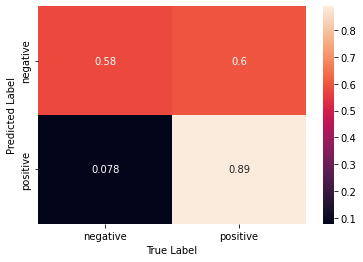

In [ ]:
#plotting the confusion matrix
names = ['negative','positive']
cm = confusion_matrix(predict_ce, y_ce)
cm = (cm / cm.astype(np.float).sum(axis=1))
sns.heatmap(cm, annot = True, xticklabels = names, yticklabels = names)
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")
plt.show()

**4.1.3.Visualize  the  sentiment prediction  results  and  the  true  sentiment  for  each  of  the 4 parties.**

Here I am choosing the LogisticRegression with the best hyperparameters and bag of words features. We can observe high accuracy for the LogisticRegression model compared to other models and features combinations.

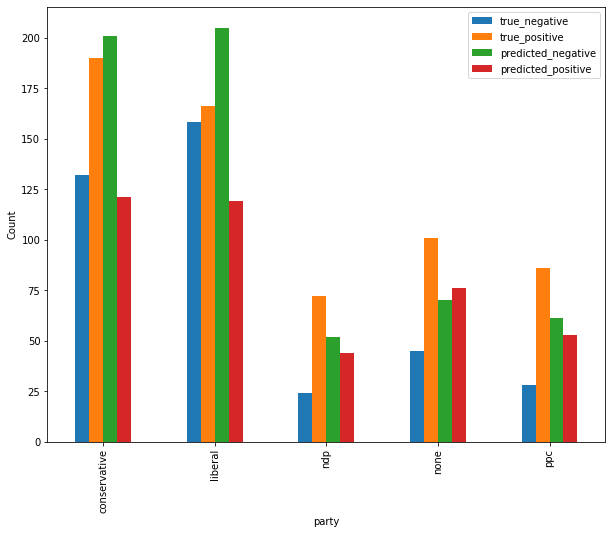

In [ ]:
matching_df.plot(kind='bar', figsize=(10,8))
plt.ylabel('Count')
plt.show()

The visualization shows that the model has classified more negative sentiments and less number positive sentiments compared to the actual data for all the parties.

**Discussing  findings  and whether  NLP  analytics  based  on  tweets  is useful for political parties during election campaigns.**

NLP analytics could be used for the political party's election campaigns. People will be posting various negative tweets/ posts on social media. So, we can collect the data related to each respective party and run those through the model. We could predict the reason for those negative tweets/ posts and analyze the data. People running in the election can try to improve those by proposing the solutions for the issues in the new manifest and explaining the reason for the initial cause of issue.

In [ ]:
#negative tweets analysis
ce_data_negative = ce_data[ce_data['sentiment']=='negative']
ce_data_negative.negative_reason.value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

Here we can observe that healthcare and marijuana, women's reproductive rights and racism, and segregation are low in number and could be grouped together as Social issues.

In [ ]:
word_list = ['healthcare and marijuana', 'women reproductive right and racism', 'segregation']

for word in word_list:
    ce_data_negative.negative_reason.replace(word,"social issues",inplace=True)

ce_data_negative.negative_reason.value_counts()

others                    149
calling election early     73
tell lies                  61
covid                      25
economy                    20
gun control                16
climate problem            15
scandal                    14
social issues              14
Name: negative_reason, dtype: int64

In [ ]:
ce_data_negative_df = pd.DataFrame(ce_data_negative.negative_reason.value_counts())
ce_data_negative_df

,negative_reason
others,149
calling election early,73
tell lies,61
covid,25
economy,20
gun control,16
climate problem,15
scandal,14
social issues,14


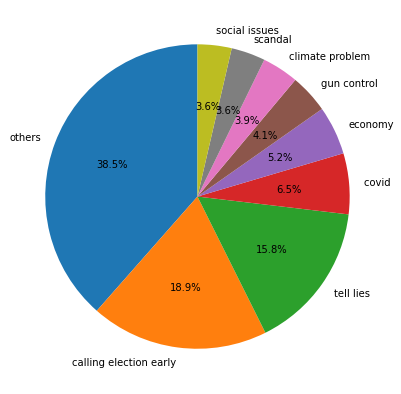

In [ ]:
#creating datasets
reasons = ce_data_negative_df.index
total = len(ce_data_negative.negative_reason)
weights = []

for each in ce_data_negative_df.index:
    weights.append(ce_data_negative.negative_reason.value_counts()[each]/total)

#creating pie-plot
fig = plt.figure(figsize =(10, 7))
plt.pie(weights, labels = reasons, autopct='%1.1f%%', startangle=90)
  
#show plot
plt.show()

The above pie plot represents the weightage of each negative reason in the negative sentiment tweets. We can observe the most common negative reason is people classifying the reason as others, and calling the election early is the second-highest negative reason in the data.

By analyzing the given data and predicting the sentiment for each information, we can get the public opinion on each party and expect the election outcome for the respective term. If the model performance is good, the party with the highest count in the negative sentiment will be likely to lose in the election. The model accuracy is not good in our case, so we cannot predict the potential winner in elections.

There are many ways to increase the accuracy of the model:
1. By training the model with more training data.
2. By performing extensive data cleaning.
3. By performing precise class representation using features.
4. By using high-performance models from neural networks and deep learning.

**4.2**

In [ ]:
ce_data_negative.negative_reason.value_counts()

others                    149
calling election early     73
tell lies                  61
covid                      25
economy                    20
gun control                16
climate problem            15
scandal                    14
social issues              14
Name: negative_reason, dtype: int64

In [ ]:
#label encoding the negative reason
labelencode = LabelEncoder()
labelencode.fit(ce_data_negative.negative_reason.unique())
ce_data_negative.negative_reason = labelencode.transform(ce_data_negative.negative_reason)

In [ ]:
ce_data_negative.negative_reason.value_counts()

5    149
0     73
8     61
2     25
3     20
4     16
1     15
7     14
6     14
Name: negative_reason, dtype: int64

In [ ]:
ce_data_negative.head()

,text,sentiment,negative_reason,party,word_count
0,canadian election power grab pm trudeau yes ta...,negative,0,liberal,9
1,hope trudeau loses canadian election tomorrow ...,negative,2,liberal,8
3,canadian friend never forget trudeau year mand...,negative,0,liberal,12
5,vaccine gun key election otoole ha serious pla...,negative,2,conservative,3
6,im sorry moderator respond leadership candidat...,negative,5,none,11


In [ ]:
X = ce_data_negative.text.astype(str)
y = ce_data_negative.negative_reason
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 9)

In [ ]:
#selecting bag of words as features, as the accuracy of the model is good with this features
bag_of_words = CountVectorizer()
bag_of_words_X_train = bag_of_words.fit_transform(X_train)
bag_of_words_X_test = bag_of_words.transform(X_test)

In [ ]:
model = LogisticRegression(class_weight='balanced', multi_class = 'multinomial', max_iter=2000)

print('Traning and testing on the:', str(model), 'model, using Bag of words features.')
print('---------------------------------------------------------------------')
model.fit(bag_of_words_X_train, y_train)

#making prediction on the train set
predict_train = model.predict(bag_of_words_X_train)
#making prediction on the test set
predict_test = model.predict(bag_of_words_X_test)

#evaluating the model
accuracy_train = accuracy_score(predict_train, y_train)
accuracy_test = accuracy_score(predict_test, y_test)

#calculating the F1_Score
f1_test = f1_score(predict_test, y_test, average='weighted')

#calculating precision and recall
precision_test = precision_score(predict_test, y_test, average='weighted')
recall_test = recall_score(predict_test, y_test, average='weighted')

print('Accuracy for Train data:', accuracy_train)
print('Accuracy for Test data:', accuracy_test)
print('F1_score:', f1_test)
print('Precision Score:', precision_test)
print('Recall Score:', recall_test)
print('---------------------------------------------------------------------\n')

Traning and testing on the: LogisticRegression(class_weight='balanced', max_iter=2000,
                   multi_class='multinomial') model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 1.0
Accuracy for Test data: 0.5641025641025641
F1_score: 0.5776640352259648
Precision Score: 0.6238600439181835
Recall Score: 0.5641025641025641
---------------------------------------------------------------------



In [ ]:
#hyperparameter tunning
logreg = LogisticRegression(class_weight='balanced', multi_class = 'multinomial', max_iter=2000)

parameters = dict()
parameters['solver'] = ['lbfgs','newton-cg','liblinear','sag','saga']
parameters['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
parameters['C'] = [0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]

tunned_model = GridSearchCV(logreg, param_grid = parameters, cv=5)

#execute search using bag of words features
best_model = tunned_model.fit(bag_of_words_X_train, y_train)

#summarize result
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)

Best Score: 0.5148148148148148
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
#LogisticRegression with hyperparameters
model = LogisticRegression( class_weight='balanced', multi_class = 'multinomial', max_iter=2000, C=0.1, penalty='l2', solver='lbfgs')

print('Traning and testing on the:', str(model), 'model, using Bag of words features.')
print('---------------------------------------------------------------------')
model.fit(bag_of_words_X_train, y_train)

#making prediction on the train set
predict_train = model.predict(bag_of_words_X_train)
#making prediction on the test set
predict_test = model.predict(bag_of_words_X_test)

#evaluating the model
accuracy_train = accuracy_score(predict_train, y_train)
accuracy_test = accuracy_score(predict_test, y_test)

#calculating the F1_Score
f1_test = f1_score(predict_test, y_test, average='weighted')

#calculating precision and recall
precision_test = precision_score(predict_test, y_test, average='weighted')
recall_test = recall_score(predict_test, y_test, average='weighted')

print('Accuracy for Train data:', accuracy_train)
print('Accuracy for Test data:', accuracy_test)
print('F1_score:', f1_test)
print('Precision Score:', precision_test)
print('Recall Score:', recall_test)
print('---------------------------------------------------------------------\n')

Traning and testing on the: LogisticRegression(C=0.1, class_weight='balanced', max_iter=2000,
                   multi_class='multinomial') model, using Bag of words features.
---------------------------------------------------------------------
Accuracy for Train data: 0.9518518518518518
Accuracy for Test data: 0.5299145299145299
F1_score: 0.5240765505974364
Precision Score: 0.5348885001960277
Recall Score: 0.5299145299145299
---------------------------------------------------------------------



With Hyperparameter tunning, we are able to reduce the overfitting in the training data. But there was a slight decrease in the accuracy.

In [ ]:
pd.DataFrame(ce_data_negative.negative_reason.value_counts(sort=False))

,negative_reason
0,73
1,15
2,25
3,20
4,16
5,149
6,14
7,14
8,61


In [ ]:
pd.DataFrame(y_test.value_counts(sort=False))

,negative_reason
0,32
1,6
2,4
3,7
4,2
5,43
6,2
7,2
8,19


In [ ]:
print('classification_report:\n\n', classification_report(predict_test, y_test))

classification_report:

               precision    recall  f1-score   support

           0       0.78      0.81      0.79        31
           1       0.33      1.00      0.50         2
           2       0.25      0.10      0.14        10
           3       0.43      0.75      0.55         4
           4       1.00      0.67      0.80         3
           5       0.53      0.52      0.53        44
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.32      0.27      0.29        22

    accuracy                           0.53       117
   macro avg       0.40      0.46      0.40       117
weighted avg       0.53      0.53      0.52       117



From the above classification report, we can observe that data has imbalanced classes. The classes with the lower count are not classified correctly; this is due to the training data being biased toward the class with a large count in data.

In the above example, 1, 2, 6, 7 classes have low occurrences in the original data and have f1-scores as 0.50, 0.14, 0.00, 0.00 from the classification report. The model cannot predict the classes with less count; it's biased toward those with a high count.

We can improve the accuracy of the model by: 
* Collecting more data
* Resampling the data
* Generating samples which is uniformly distributed between all the classes
* Using penalizing algorithms like penalized-SVM and penalized-LDA
* Using advanced machine learning algorithms

I had combined healthcare and marijuana, women reproductive right and racism, segregation negative reasons, to social issues, performed at the above steps.

I used a bag of words features for word frequency analysis, as there is a good accuracy score compared to the TF-IDF.

**4.3. Use the frequency of the words (Bag of Words) for (i) positive and (ii) negative tweets using the ground truth sentiment to rank the top-50 most frequent non-stop-words in the Canadian elections dataset. Use the true sentiment labels in the Canadian elections data. Discuss your findings.**

In [ ]:
ce_data_pos_text = ce_data.text[ce_data['sentiment']=='positive']
ce_data_neg_text = ce_data.text[ce_data['sentiment']=='negative']

print('Number of tweets with positive sentiment in Canadian elections data:',len(ce_data_pos_text))
print('Number of tweets with negative sentiment in Canadian elections data:',len(ce_data_neg_text))

Number of tweets with positive sentiment in Canadian elections data: 615
Number of tweets with negative sentiment in Canadian elections data: 387


In [ ]:
bag_of_words = CountVectorizer()
bag_of_words_pos = bag_of_words.fit_transform(ce_data_pos_text)
bag_of_words_pos_df = pd.DataFrame(bag_of_words_pos.toarray(),columns = bag_of_words.get_feature_names())
bag_of_words_pos_df

,abacusdataca,abandoned,abbound,abc,ability,able,abpoli,abroad,absolutely,absurd,abtitan,accept,acceptable,accepting,accessible,according,account,accurately,acknowledging,acknowledgment,acoyne,across,act,action,actioncanadashr,actual,actually,ad,adambolt,add,adore,adoring,adult,advance,advanced,advantage,advice,affect,affordable,africa,...,working,world,worry,worst,worth,worthwhile,would,wouldnt,wow,wrong,wrote,wtg,xi,xychelsea,ya,yall,yea,yeah,yeahpraises,year,yelling,yes,yeshe,yesterday,yesyesyes,yet,ymm,yo,youll,young,youre,youth,youthvote,youtube,youve,yvonneyyz,yyc,zazzle,zero,zerochance
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bag_of_words = CountVectorizer()
bag_of_words_neg = bag_of_words.fit_transform(ce_data_neg_text)
bag_of_words_neg_df = pd.DataFrame(bag_of_words_neg.toarray(),columns = bag_of_words.get_feature_names())
bag_of_words_neg_df

,aa,ab,abandoning,abc,abhorrent,ability,ablais,able,abled,ableg,abpoli,absent,absolutely,abuse,abuser,abusive,accept,accomadation,accomplishment,according,account,accountable,accuse,accusing,achievable,achieve,acoyne,act,acting,action,activity,actor,actual,actually,ad,adamscotti,adding,addled,address,adjunct,...,worldwide,worn,worried,worry,worrying,worse,worst,worth,worthless,would,wouldnt,wow,wrecking,write,wrong,wrongdoing,wtaf,wtf,wth,yahoo,yall,yankee,yeah,year,yeg,yelled,yes,yeshis,yesterday,yet,yo,youknowwho,younger,youre,youtube,youve,youwe,yup,zealot,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pos_sum = bag_of_words_pos_df.sum(axis=0)
pos_sum = pd.DataFrame(pos_sum)
pos_sum.sort_values(by=0, ascending=False, inplace=True)
pos_sum.reset_index(inplace=True)
pos_sum.columns = ['positive_word','positive_count']

#printing top 50 words in the positive tweets text
pos_sum[:50]

,positive_word,positive_count
0,election,426
1,canadian,316
2,vote,198
3,trudeau,170
4,otoole,143
5,canada,138
6,party,86
7,good,74
8,elxn,73
9,win,72


In [ ]:
neg_sum = bag_of_words_neg_df.sum(axis=0)
neg_sum = pd.DataFrame(neg_sum)
neg_sum.sort_values(by=0, ascending=False, inplace=True)
neg_sum.reset_index(inplace=True)
neg_sum.columns = ['negative_word','negative_count']

#printing top 50 words in the negative tweets text
neg_sum[:50]

,negative_word,negative_count
0,election,268
1,canadian,207
2,trudeau,147
3,otoole,119
4,canada,77
5,vote,48
6,pandemic,48
7,justintrudeau,47
8,ha,47
9,elxn,45


In [ ]:
print('common words between top 50 positive and negative tweets:')
for each in pos_sum[0:50].positive_word:
  if each in np.array(neg_sum[0:50].negative_word):
    print(each)

common words between top 50 positive and negative tweets:
election
canadian
vote
trudeau
otoole
canada
party
good
elxn
win
get
liberal
conservative
like
day
cdnpoli
wa
ha
want
leader
justintrudeau
dont
erinotoole
people
time
would
justin
think
one


There are many common words between the top 50 positive and negative tweets text words.<br>
The topmost repeated words in the positive tweets are {election, Canadian, vote, Trudeau, otoole}.<br>
{election, Canadian, Trudeau, otoole, canada} were the top words in the negative tweets. We can see Trudeau and otoole are common and most repeated words in positive and negative tweets, as many people have posted positive and negative tweets referencing them.